Processing speech and predicting completion:

Batch  | Topics | Novelty | Staleness | Completion | Status
----------------------------------------------------------------------
1      | 4      | 1.0000  | 0.0000    |    0.0%    | [                    ]
2      | 3      | 1.0000  | 0.0000    |    1.1%    | [                    ]
3      | 4      | 1.0000  | 0.0000    |    0.9%    | [                    ]
4      | 5      | 1.0000  | 0.0000    |    1.3%    | [                    ]
5      | 4      | 0.9268  | 0.1831    |    3.7%    | [                    ]
6      | 4      | 1.0000  | 0.0000    |    3.8%    | [                    ]
7      | 4      | 1.0000  | 0.0000    |    4.0%    | [                    ]
8      | 5      | 0.9414  | 0.1464    |   14.7%    | [==                  ]
9      | 5      | 1.0000  | 0.0000    |   14.9%    | [==                  ]
10     | 5      | 0.8569  | 0.2113    |   17.2%    | [===                 ]
11     | 5      | 1.0000  | 0.0000    |    6.9%    | [=        

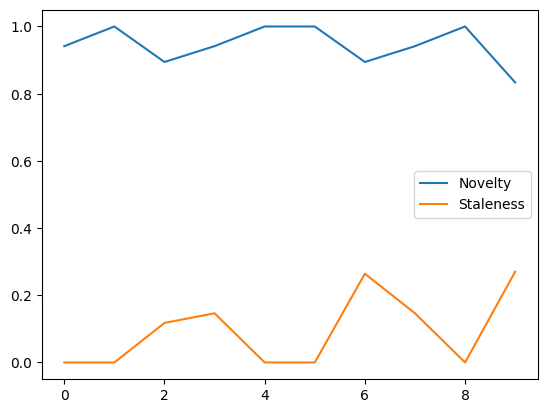

In [12]:
import re
import numpy as np
import torch
from sentence_transformers import SentenceTransformer, util
from sklearn.cluster import DBSCAN
from scipy.spatial import distance
from collections import deque
from transformers import AutoTokenizer
from sklearn.cluster import AgglomerativeClustering

tokenizer = AutoTokenizer.from_pretrained('sentence-transformers/all-mpnet-base-v2')

# Text preprocessing functions
def clean_text_spacing(text):
    text = re.sub(r'(?<=[.!?])(?=\w)', r' ', text)
    text = re.sub(r'(?<=[.,!?;:])(?=\S)', r' ', text)
    return text

def split_into_sentences(text):
    sentence_endings = re.compile(r'(?<=[.!?])\s+(?=[A-Z])')
    return sentence_endings.split(text)

# Load sample text
text_test = """Thank you. What a nice group. Thank you very much. Beautiful, thank you.We love our senior citizens. And I’m honored to be here in Fort Myers to reaffirm my solemn pledge to America’s seniors, it’s so important to me, I happen to be a senior. I will protect you, I will defend you, and I will fight for you with every ounce of energy and conviction that I have. You devoted your life to this country and I am devoting my life to you. My administration is working every day to give our amazing senior citizens the care, support, and respect that you deserve, and you understand that, we’ve worked together for a long time. As president, I’m deeply aware that America’s 54 million seniors have borne the heaviest burden of the China virus. Many older Americans have endured months of isolation, missing weddings, births, graduations, church, and family reunions, you know that very well, you know it all too well. My heart breaks for every grieving family that has lost a precious loved one, I feel their anguish, and I mourn their loss, I feel their pain.I know that the terrible pain that they have gone through, and you lose someone, and there’s nothing to describe what you have to bear, there’s nothing to describe it. In times of challenge, we turn to our fellow Americans for a shoulder to lean on and we turn to God for healing and strength, and together we will overcome. My message to America’s seniors today is one of optimism, confidence, and hope. Your sacrifice has not been in vain. The light at the end of the tunnel is near. We are rounding the turn, I say that all the time, some of the media doesn’t like hearing it, but I say it all the time, we’re rounding that turn. Don’t listen to the cynics, and angry partisans, and professional pessimists, we are Americans and we will prevail, we are prevailing, and we are… It’s amazing what’s happening, if you look at what’s going on, it’s been really very amazing.I’m moving heaven and earth to safeguard our seniors from the China virus to deliver life-saving therapies in record time and to distribute a safe and effective vaccine before the end of the year, and we’re really doing it even sooner than that, you see what’s going on, we have the vaccines getting ready to go. Seniors will be the first in line for the vaccine and we will soon be ending this pandemic, hasn’t happened a thing like this since 1918, 1917, that was a bad one too, that was a real bad one. I will not rest until we’ve eradicated this plague from our country, and our lives, and our world, we want it out. When the China virus arrived, we launched the largest mobilization since World War II. Our aggressive and early action saved more than 2 million lives compared to the best estimates from last spring, you remember when they were giving you estimates.Since the beginning, our nation’s seniors have been my top priority, it was obvious very early on that it was affecting the seniors not young people. Young people are… They have that strong immune system and I give all credit to them, but they have a strong immune system, and 99.99, think of that. But, when you get into people that have a few more years, it’s a little bit more difficult, when you get a lot more years, it’s a lot more difficult. But, what they’ve done with therapeutics now and what they’ve done with all of the other things that they’re doing, it’s incredible. We heightened mitigation and surge testing to protect those at highest risk. We sent billions and billions of dollars in funding to personal protective equipment and distributed rapid testing to 15,400 nursing homes all over the country.We’ve worked with a lot of governors and some have done a great job, and some have done not a great job, and some have done a very poor job, actually, but some have done a great job, but we’re working very closely with the governors of the states. Just this week, even the New York Times, this was shocking, was forced to admit that ‘experts are saying with genuine confidence that the pandemic in the United States will be over far sooner than they expected’. And they’re right, but I was shocked to hear coming out of the New York Times, right? I was a little [inaudible 00:05:55], and it’s thanks to my administration’s Operation Warp Speed, incredible people. Because of advances in treatment we pioneered, and we have many treatments, but because of these great advances, we’ve reached the point where the fatality rate is reduced by 85% since April and now it’s up to probably 91%. Well, I’m here, I tell you.Thank you. Well, I don’t know what they gave me, but give me some more of it right now and you can have some too. No, I know exactly what that gave, it was actually pretty amazing. I’m also working with the FDA and HHS to make the antibody treatment that I received, it’s called Regeneron plus… Also, it’s incredible, and what they can do today is incredible. And they felt very confident even six months ago when they started, think of it, we got this all done in a very short period of time and now we’re going for emergency use, because we’re going to make it available to everyone who needs it for free, anybody in the country. And Eli Lilly is making a very similar drug, and Alex, they’re working very hard on that, right? Alex Azar, so thank you very much, because I want people to get it and we’re getting it free, right? So, we got to do that. If you need it, if you don’t need it, that’s even better, okay? That’s even better, but if you need it, right? You get it.It’s really pretty amazing what happened, because I wasn’t feeling great and the next day I wake up and I’m saying, “Who can I fight today?” Thank you. So, our groundbreaking therapies have significantly improved and improved our outcomes for elderly patients, but I’ll not relent until all American seniors are safe, you’re going to be safe, a hundred percent safe, and we’re at a point where really so much progress has been made. Under Operation Warp Speed, we’re on track to deliver at least 100 million doses of a vaccine this year, and could even be a little bit sooner than what they were originally anticipating, with hundreds of millions more to quickly follow, Alex, remember that Alex. Today, I’m thrilled to announce that we have just finalized a partnership with CVS and Walgreens, two places you know pretty well, I guess, to immediately deliver the vaccine directly to nursing homes at no cost to our seniors, right? No cost.These are very effective, once you have that vaccine you can open those doors and say, “Here I am.” But with everything that I say and everything I do, if you feel safer at home… And we can all be like, ” Let’s get out there.” And I felt as president, I knew there was risk, but I had to be out, I can’t just be locked in a basement, to put it… Lock them in a basement. I felt I had to be out there, I would see Gold Star families, [inaudible 00:00:09:44], and I’ve been looking forward for months to come into the White House, and many, many other people, military people and heads of state. And I know you put yourself at risk, but you can’t… You have to lead your life. But I say this, there are people also that would rather stay in place, stay where you are, and to those people, and I understand that very well, stay, just relax, stay until it’s gone, and it’ll be gone, but stay. Don’t feel badly or don’t feel good about it, just stay, if you feel safe, stay.I’m working as hard as I can so you can kiss and hug your children and grandchildren very soon, that’s something I missed also, I will be honest with you. As we shelter high-risk Americans with extreme vigilance, we must also allow lower-risk Americans to return to work and return to school. I mean, children should go to school. My young son, Baron, had it, and he had it, and all of a sudden he doesn’t have it, it’s like… It was different, it’s a whole different deal, and they should go to school, and they have to, because… I talk about the cure, right? It cannot be worse than the problem itself, it’s a very simple statement, but the cure cannot be worse than the problem itself. And with young children, they have to go to school, they have to be with other kids, they have to grow up, they can’t lose a year of their life. And if you look at some of these lockdowns that the Democrats are doing in some states, if you look at North Carolina, and Pennsylvania, and Michigan, we won the case against her in Michigan.I mean, she’s running like a prison except for her husband who’s allowed to go boating, that doesn’t work out somehow. Fortunately, they caught him, he was going to go on the lake boating, that’s nice, but nobody else was allowed to do it. But we won the case against her for Michigan, and we freed up the state, and it’s a great thing, I mean, it’s a great thing, we freed up the state. Because that whole thing with drugs, and alcohol, and depression and all of the horrible things, we could go over a long list of things, but we can’t let that happen. So, we want the Democrat, radical left, in many cases, Democrats, we wanted to open their states, open up your states, and we’re very careful with our seniors, and that’s different, but open up your states, get it back.Despite punishing society-wide lockdowns in Europe, I don’t know if you’ve been watching, they’re now experiencing a massive surge in cases. Daily cases are 2500% higher in the United Kingdom, as an example, and 722% higher in Europe than in the United States, okay? No, think of that. And we wish them… And we’re working with them closely, we’re making ventilators for them. For many of the countries over there, we became the ventilator king. I mean, we didn’t have many ventilators, we had… Really, we inherited bare cupboards, I said the cupboards were bare, in many of the states they had… Cupboards were bare, and now they’re loaded up and they’re ready…Cupboards were bare. And now they’re loaded up and they’re ready. But the hardest thing are the ventilators because of the complexity of the machine, and the cost, the size, but the pure complexity. And we make thousands of ventilators now a month and we’re sending them all over the world. We’re all set with the ventilators but we’re sending them all over the world. But hopefully you won’t need them. Soon you won’t even need them. I really think you’re going to not need the ventilators, hopefully soon, very soon. But sadly in Europe, the average daily deaths are really soaring. 402% higher in the United Kingdom. 493% higher in Europe. Meanwhile, in the United States deaths have decreased by 37%. So that’s something, right.The fake news doesn’t want to tell you that, right? They want no piece of that. They don’t want anything to do with that. So whether you’re Republican or Democrat, we must use facts over fear. We have to. Science over hysteria, hope over despair, and the common good over partisan politics. And again, if you feel good, if you feel safe because it’s going to be gone, stay where you are. Don’t leave. Don’t say, “Oh gee, I have to get out.” The President said, “Let’s get out.” Stay where you are. I have a lot of friends, they’re strong people. They’re senior citizens. Great people, very successful people. Hi. Look, she’s waving. Hi. Thank you. Thank you, hun.But you know they’re tough actually, but they feel comfortable until this has gone and there are people, and I do that. Do that. I might do that. If I weren’t in this position, maybe I’d be doing it myself. In this position, it’s a little tougher. But we cannot allow unscientific, panic driven, fear-based policies to deny our children and grandchildren their future, and their dreams. We can’t take a year or two years out of their lives. There’s a whole social thing going on there too.These left wing lock downs will crush America, and my plan is very simple. We’re going to crush the virus and go back to exactly where we were. We’re almost getting back there now. So together, we will end this pandemic. We will rebuild our economy and we will ensure our seniors can live long, happy, secure, and healthy lives with your grandchildren and your children. You’re going to hug them, right? It’s good. Under my leadership next year will be one of the greatest years in the history of our country economically. We’re grateful to be joined today by Secretary of Health and Human Services, Alex Azar. Alex, we’re counting on you. We’re counting… I’m going to blame him if this stuff doesn’t happen fast, right?Centers for Medicare and Medicaid services, a fantastic woman, Administrator Seema Verma. Thank you, Seema. Great job you’re doing. A friend of mine who’s become very, very popular, I guess that was what that big applause was. I was backstage, I said, “Who just came in?” I thought Elvis entered the room. It was your Florida Governor, Ron DeSantis. Stand up. That’s great, Ron. Great.And by the way, we have some crowd. You see what’s going on outside? The mayor said, “He’s never seen anything like that. He’s never seen anything.” Now there’s a lot of love outside. I want to tell you. That’s a lot of love and we’re leading in the State of Florida, just so we understand. By perhaps a lot. Also with some warriors, Representatives Gus Bilirakis. Gus, Gus, great job, Gus. And another friend of mine, these are really terrific people, Greg Stube. Greg, thank you very much, Greg. Thank you. Thanks as well to Fort Myers, Mayor Randy Henderson. Randy. Thank you. Thank you, Randy. Good job, Randy. That’s quite a crowd, huh?That’s good. Thank you very much. And Cape Coral Mayor Joe Coviello. Joe Coviello. Thank you, Joe. Great job. Great job. We’re also tremendously honored to be joined by World War II and Korean War veteran, a very brave guy, Wally Cortese. Wiley Cortese. Thank you, Wally. You look good, Wally. I’ll tell you, two wars and you’re looking good. Thank you, Wally. Appreciate it. Beautiful. Thank you very much. Thanks also to all of the members of the VFW Golden Gate Honor Guard, they’re with us today. Thank you. That’s so great. That’s so great. VFW. Fantastic job. Thank you very much for being here. As I fight to protect our amazing seniors from the China virus, I’m also fighting to protect you from another danger. One, which threatens everything we cherish, value and worked our entire lives to build and to defend. As we gathered today, seniors are under threat from a radical left movement that seeks to destroy the American way of life. We’re not going to allow it. And you know one thing, sleepy Joe and do nothing about it. The left has been taken over by socialists and Marxists and extremists and they have. They want to transform our nation into a country that would no longer be recognizable. And their agenda will shatter America’s seniors, their plan to delay the vaccine, delay therapies and prolong the pandemic will cost thousands and thousands of lives, will be horrifying for our country.
They are planned for higher taxes. They want to quadruple taxes. Every company will move out. They’ll go back to where they came. We had tremendous people, tremendous companies come into our country. We’re bring in tremendous jobs, 160 million jobs, we’ve never had anything like it, before the plague and then we’re building it back up again. Last four months, we’ve set records on employment, on hiring employment. And a number that, let’s say a year ago, wouldn’t have sounded great, but now sounds incredible, 7.8% unemployment. Think of it. People were talking about 42%. We’re back down to 7.8 and we’ll be soon down to the number where we were, seven months ago. Pretty amazing.I never thought I’d be happy with 7.8%, but you know when you think about it, right, they were talking 39%, 42%. Ron, 7.8 is a pretty amazing thing. We did that in a rapid fashion. Nobody’s ever seen anything like it, actually. They’re planned for higher taxes and crippling regulations, however, would crater our economy. Their insane energy policies because you know they’re going to be fracking. Hey, Biden for a year and a half is saying there will be no fracking. Then he looks out, he gets the nomination because Elizabeth Warren refused to get out. So Bernie, a second time, that happened twice to Bernie. Bernie, he’s a hell of a loser. That’s one thing I’ll say. He knows how to lose. He knows how to lose. He loses he goes back to work like nothing happened. No, they took it away from him twice. I think the second time in a way worse, because she stayed in, she took the votes and sleepy Joe just got in there. That’s why you got to be careful. You got to be careful. You never know what happens.But if you take a look and we can’t let any of this stuff happen. And you look at what’s happened to other countries, where they’ve had this philosophy, where they’ve had this ideology. We can’t let… But you watch what they’re saying about the fracking, where he said no, and he said it with such… It’s not like, “Well, I’ll think about it.” He’s doing the same thing with the courts right now. They’re going to pack the Supreme Court. You see what they want to do. Would be destruction of our country. But you take a look. So he says, “No, there will be no fracking.” These are the words. “There will be no fracking. You don’t understand what I just said. There will be no fracking.” And then he gets very agitated. “There would be no fracking.”And he gets a nomination, goes to Pennsylvania, they inform him that they have a million jobs and fracking’s a big deal. And they like inexpensive energy, right? And so, he goes from, “There will be no fracking with great anger”, to “I never said they wouldn’t be fracking.” It’s the craziest thing. If that ever happened to me and the media doesn’t even talk about it. That’s just one of many things. Then he does that thing with the courts. You see that, right? He goes, “I’ll tell you after the election what I’m going to do.” How important is it? Because he’s going to put on radical, left, crazy judges that will destroy your lives. It’s the most important. They’ve always said… I’ve always heard, Ron, I’ve always heard this, that the most important thing a president does is pick Supreme Court Justices, right? I would say maybe the military, but let’s say it’s right there. And he has to create a list of more than just that, he has to create a list and let you know and he has to pick from that list. That’s what I did. I created a list of 25 people, highly, highly capable people. And a lot of people said, that’s why I won the election, actually. So I don’t know if that’s true or not. But it was a very important part, Mary, you understand mayors, you know that.So their insane energy policies will abolish millions of jobs and cost seniors thousands of dollars per year in higher energy bills. Their anti-police agenda will empower violent mobs and put every community at risk. Their anti-suburban agenda threatens the property values of millions of American seniors and your families, who own homes in residential neighborhoods, in the suburbs. I’m saving the suburbs. People saying, “Well, women in the suburbs, do they like Trump?” I said, “Yeah, they liked me. You know why they like, because I’m saving their homes.” That’s why they like me. They may not like me, but they like what I’m doing, and that’s more important.Oh boy, they have these crazy people. The people on television, I don’t know if suburban women, suburban women want security. They want safety. They want law and order. They want their homes to be protected. The socialist ideology that they will use and indoctrinate our youth with is like poisonous Anti-American propaganda.The plan by Washington Democrats to give amnesty and free healthcare to illegal border crossers will obliterate Medicare, bankrupt your social security, robbing you of the benefits that you’ve paid for your entire lives. Look, take a look at Venezuela. People don’t realize, that was a wealthy country 18, 17 years ago. It was so wealthy. And it’s gone from being wealthy, they don’t have medicine, they don’t have food, they don’t have water. They don’t have anything. And it can happen here, just a much larger version with that ideology. And that’s the ideology that they’re looking at. It’s crazy.These radicals will destroy Medicare with totally open borders. And by the way, you know the wall, it’s up to almost 400 miles. 400. 400 miles. And it goes down deep, tunneling. It goes down deep and up very high. Now it’s had a tremendous… We’ve never had a stronger Southern border than we have right now. It’ll be finished very soon. We’re doing 10 miles a week. That’s a lot. 10 miles a week. Army Corps of Engineers are also doing Lake Okeechobee and lots of other things, right? They’re doing a good job, right? They’re giving away your benefits, that’s what-They’re giving away your benefits, that’s what they want to do to anyone in the world who trespasses into our country. And we all have big hearts and we want to take care of people. But when you say, “We’re going to give you free healthcare. We’re going to give you college education.” I sarcastically said once, “We’re going to give you a beautiful brand new Rolls-Royce. Okay? If you’re an illegal immigrant. And CNN went and they said, “The President lied to the seniors.” They just don’t get it. They get it. Actually, unfortunately they get it more than you would think. They’re a little bit on the evil side.But, you’re going to bring millions of people … You’re going to bring millions and millions of people. It’s like, when you say, “Free healthcare, and free education, and free this and that,” millions of people are going to pour into the country. It’s not going to be stoppable. And we can’t let that happen. They care more about illegal aliens than they care about senior citizens, the Democrats. The left is coming after me because I’m defending you. And that’s true. That’s why they come after me. Every day they come … But we caught them on the Russian hoax. We finally caught them after two and a half years. Russia knows. Turned out to be the exact opposite. They’re the ones that were playing with Russia. That was a beauty. Hillary … Crooked Hillary. Now they’re the ones. Yeah, I agree with you. I used to just be quiet. And I agree with you 100%. Millions and millions of dollars they paid. And they tried to show it. It was the greatest hoax and the greatest political crime in the history of our country. That’s what they committed. But I’m the only one standing between their open borders and extremism and the healthcare benefits that you’ve earned and paid for. All your life, you paid for. As long as I’m President, no one will lay a hand on your Medicare or your social security. As a candidate, I made a sacred promise that I’d strengthen, protect and defend your Medicare benefits. And that’s exactly what I’ve done. I’ve done that, right?My administration’s fought to deliver greater security, affordability, fairness, economic stability to our nation’s seniors. Under eight years of the previous administration, premiums for Medicare health plans went up including a 25% increase right here in Florida. That’s for the previous people. Under my administration, we’ve lowered Medicare Advantage premiums by a number nobody even believes, 34% nationwide. And today, it’s the lowest level in 14 years. Did you know that, Ron? That’s not a bad thing for you to put into your speech, right? Who would think that? No, but seriously, we’ve brought it way down. This group over here, they’ve done a great job. Thanks to our efforts, there are 2,000 … Thank you.There are 2,000 more Medicare Advantage plans today than there were three years ago. That’s incredible. Think of that. That means more choice and more competition for better care at a much lower cost. When we rapidly expanded telehealth for Medicare beneficiaries during the pandemic, the number of tele-health users increased from 14,000 a week to 1.7 million a week. What’s that percentage? Yet, all of this danger, it’s all in danger because if these other people get in, they will end all of that. The telehealth … It’s interesting. We’ve learned something for children, they’re much better in a classroom than they are on a laptop. Okay? Children.But for your health and what you can do, you can do so much of it, such a big percentage, better than going out and going through … This telehealth has been amazing. It’s been really incredible. It’s been an incredible thing. It’s increased like six, 7,000, I think 6500%. And it’s probably the only thing that came out of this whole deal that we really can take pleasure at, telehealth. It’s been really an incredible thing that’s happened. Over 130 Democrats in Congress, including far left Senator Kamala Harris, who is the most … I said, “He’ll never choose her because nobody treated him worse than her. Nobody.” Plus, her poll numbers were sinking. She never even got to Iowa. She never got there. And when I said, “Oh … ”And by the way, didn’t Mike Pence do a good job the other night? Right? Good man. Did a great job. And I had a great … Thank you. Really, I had a lot of fun last night with that. That was a nice evening. It was a nice pleasurable evening. I had somebody going totally crazy last night. “But, I told you … I told you that.” She told me? She’s going to … Oh, okay. I believe you, right? No, but I understand that worked out very well last night. That’s what the word is, so that’s good. Another evening in paradise, I call it. They’re sponsoring a socialist healthcare plan that would annihilate your Medicare. The Democrats’ policy proposals may go by different names. They put all sorts of names. They say single payer, or so-called the public option.But really, they’re all based on the same core promise, raiding Medicare to fund a socialist healthcare takeover. And it’s going to destroy your Medicare. That’s the one thing you know for sure. Every one of their plans involves rationing care, restricting access, denying coverage, slashing quality, extending wait times and massively raising your taxes. Other than that, it’s actually quite good. As we know from seeing these left wing policies in action around the world, seniors will be the victims. And that’s what happens, the first to go are the seniors, the victims are really the seniors. This is nothing that unique. Socialist healthcare plans always end up denying care and coverage to the sick and the elderly in order to control costs.And they always feel that this is the easiest way to do it. We must not let them bring this lethal and deadly agenda to America. Don’t let it happen. Got to vote them out. Get out and vote. Democrat healthcare proposals would abolish private insurance for 180 million Americans. Just so you know, there are many people, they’ve had a good life, they’ve done well. They have private plans. They are unbelievable. They love their plan. Those plans are gone. Those plans are gone. They’d abolish the Medicare Advantage program that benefits 24 million seniors, including one out of two Hispanic seniors and one out of three African-American seniors who enrolled in the Medicare Advantage. Right?And that will all be ended. It would be abolished, for big fat, ugly socialized medicine. You go to a hospital, you don’t feel good. Go to a hospital room and wait for three days to see a doctor. I will never allow that to happen. Under my administration, your Medicare Advantage is safe. Your benefits are protected. And I will always protect patients with pre-existing conditions, always, always, always. They always play that card, right? Remember they used to say, “Oh, he’s going to give up.” At first they said I was going to be in a war within the first week. Whatever happened to that, right? Just the opposite. Our great warriors are coming home. They’re all coming home. They’re all coming home. You’re welcome.Look at North Korea, they thought would be a war and a war immediately with North Korea. How’s that worked out, right? It’s worked out very nicely. Talk, we’ll talk, keep talking. But it worked out very well. But the other thing they said, “He will destroy your social security.” Really? Did I? I said, “No.” No, they’re going to destroy it, because they’ll destroy our country. They’ll destroy your social security and they’ll destroy your country. And Joe won’t have any idea what happened, because he’s gone. Let’s face it. He’s gone. Another critical issue for senior citizens is the price of prescription drugs. This is something I’m very proud of, because we’ve lowered Part D prescription drug premiums by 12%, saving senior citizens $1.9 billion.But the biggest yet to come, I stood up to big pharma, and that’s not easy. They got big money. They’re the biggest lobbyist in this country by far. And I signed an executive order, implemented a most favorite nations policy for the United States. For years you’ve heard, “We pay more for drugs than any other country.” Well, that’s not even close. We pay much more. And in other countries that we know very well take advantage of us and they pay a fraction. I mean, you wouldn’t even believe how much less, but a fraction. 25 cents for a pill, as opposed to $2 for a pill. Same pill from the same lab plant, right? And I instituted a favorite nations clause. I said, if Germany or some other country is getting our stuff low, I want a favored nations. Meaning, I want it for the same price. And they have gone crazy.I have never seen so many ads. They put on more ads against me now than sleepy Joe Biden, I’m telling you, and they understand. Look, it should have been done a long time ago. This should’ve been done years ago. Plus, I got rid of the middleman and I gave Ron DeSantis the right to go to Canada in the meantime, because I think eventually you’ll be using this. But in the meantime, you’ll also be getting the rebates. Okay? Rebates, you know who they go to? The middlemen. You know how rich the middlemen are? I’m rich. These guys blow everyone away. I don’t know … Nobody even knows who the hell they are. Did you ever hear … Does anybody know a middleman? I would like to meet. It’s Biden’s son. It’s Hunter. Oh, it’s Hunter. I’ll bet you Hunter is a middleman.He’s like a vacuum cleaner, he follows his father around collecting. What a disgrace. It’s a crime family. You want to know something? It’s a crime family. He’s following his father. Hunter Biden is a middleman. Oh, that’s wild. No, these people are amazing. These middlemen, you’re right. Hunter made no money until his father became Vice President and now he’s like a vacuum cleaner. His father goes to Germany, Hunter’s right there. “Hey, give me a couple of million.” Not a couple of million. Hell of a lot more than a couple of million. That’s a shame. I’ll tell you what, it’s an organized crime family, as far as I’m concerned. I capped out of pocket costs … And the way they get protected by big tech and by the media, the media doesn’t want to ask … This is the hottest subject there is right now.
And I didn’t watch sleepy Joe last night. I just wanted to see what he looked like. He wasn’t looking too good. I just couldn’t watch, it was too painful. But, they didn’t … I understand that they did not ask him a question about this. Can you believe it? Now, think of it. And Stephanopoulos interviewed me two weeks ago and he was nasty. He was nasty. I mean, he was tough. He’s a tough"
"""
cleaned_text = clean_text_spacing(text_test)
sentences = split_into_sentences(cleaned_text)

# Initialize model
model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

# Topic tracking and novelty detection system


class TopicTracker:
    def __init__(self, novelty_decay=0.2, staleness_threshold=0.65):
        self.topics = {}  # topic_id: {'centroid', 'last_seen', 'count'}
        self.next_topic_id = 0
        self.novelty_decay = novelty_decay
        self.staleness_threshold = staleness_threshold
        self.novelty_history = deque(maxlen=10)
        self.staleness_history = deque(maxlen=10)

    def update_topics(self, batch_embeddings):
        """Cluster sentences and update topic registry"""

        # Convert to numpy
        embeddings_np = (
            batch_embeddings.cpu().numpy()
            if isinstance(batch_embeddings, torch.Tensor)
            else batch_embeddings
        )

        if embeddings_np.shape[0] < 2:
            # Only one sentence — treat it as a new topic
            topic_id = self._match_or_create_topic(embeddings_np[0])
            return {topic_id: [0]}

        # Otherwise, do clustering new one agglomerative clustering
        clustering = AgglomerativeClustering(
            n_clusters=None,
            distance_threshold=0.5,
            metric='cosine',
            linkage='average'
        )
        labels = clustering.fit_predict(embeddings_np)

        # Process clusters
        batch_topics = {}
        for label in set(labels):
            if label == -1:
                # Handle noise as individual topics
                for i in np.where(labels == label)[0]:
                    topic_centroid = embeddings_np[i]
                    topic_id = self._match_or_create_topic(topic_centroid)
                    batch_topics[topic_id] = batch_topics.get(topic_id, []) + [i]
            else:
                indices = np.where(labels == label)[0]
                topic_centroid = np.mean(embeddings_np[indices], axis=0)
                topic_id = self._match_or_create_topic(topic_centroid)
                batch_topics[topic_id] = batch_topics.get(topic_id, []) + list(indices)

        return batch_topics  #  Return after processing all labels

    def _match_or_create_topic(self, new_centroid):
        # Dummy matching function for now (you can replace this with actual similarity logic)
        topic_id = self.next_topic_id
        self.topics[topic_id] = {'centroid': new_centroid, 'last_seen': 0, 'count': 1}
        self.next_topic_id += 1
        return topic_id

    def _match_or_create_topic(self, centroid):
        """Match to existing topic or create new one"""
        best_match = None
        best_sim = -1

        for topic_id, topic_data in self.topics.items():
            sim = 1 - distance.cosine(centroid, topic_data['centroid'])
            if sim > best_sim:
                best_sim = sim
                best_match = topic_id

        # Update existing topic or create new
        if best_sim > self.staleness_threshold:
            self.topics[best_match]['centroid'] = (
                self.topics[best_match]['centroid'] + centroid
            ) / 2
            self.topics[best_match]['count'] += 1
            self.topics[best_match]['last_seen'] = len(self.novelty_history)
            return best_match
        else:
            self.topics[self.next_topic_id] = {
                'centroid': centroid,
                'last_seen': len(self.novelty_history),
                'count': 1
            }
            self.next_topic_id += 1
            return self.next_topic_id - 1

    def calculate_novelty(self, batch_topics):
        """Calculate novelty score for current batch"""
        if not batch_topics:
            return 0.0

        novelty = 0
        for topic_id in batch_topics:
            topic_data = self.topics[topic_id]
            # Calculate decay based on how many batches since last seen
            if 'last_seen' in topic_data:
                batches_ago = len(self.novelty_history) - topic_data['last_seen']
                decay_factor = np.exp(-self.novelty_decay * batches_ago)
            else:
                decay_factor = 1.0  # New topic

            # Higher novelty for topics seen fewer times
            novelty += decay_factor / (topic_data['count'] ** 0.5)

        # Normalize by number of topics
        normalized_novelty = novelty / len(batch_topics)
        self.novelty_history.append(normalized_novelty)
        return normalized_novelty

    def calculate_staleness(self):
        """Calculate staleness based on novelty trend"""
        if len(self.novelty_history) < 3:
            return 0.0

        # Calculate trend of last 3 novelty scores
        recent_novelty = list(self.novelty_history)[-3:]
        x = np.arange(3)
        slope, _ = np.polyfit(x, recent_novelty, 1)

        # Staleness increases when novelty decreases
        staleness = max(0, -slope * 5)  # Scale slope to [0,1] range
        self.staleness_history.append(staleness)
        return min(1.0, staleness)

    def detect_closing_phrases(self, sentences):
        """Detect closing phrases in text"""
        closing_indicators = [
            "in conclusion", "to summarize", "finally", "lastly",
            "in summary", "to wrap up", "closing thoughts", "thank you",
            "i enjoyed our conversation", "that's all", "we've covered"
        ]

        for sentence in sentences:
            if any(phrase in sentence.lower() for phrase in closing_indicators):
                return 1.0
        return 0.0

    def predict_completion(self, current_batch_index, total_batches, sentences):
        """Predict completion percentage"""
        if len(self.novelty_history) < 3:
            # Not enough data, use position-based estimate
            position_ratio = current_batch_index / total_batches if total_batches > 0 else 0
            return min(90, position_ratio * 100)

        # Position-based completion
        position_ratio = current_batch_index / total_batches

        # Novelty decay factor
        recent_novelty = np.mean(list(self.novelty_history)[-3:])
        initial_novelty = np.mean(list(self.novelty_history)[:3])
        novelty_decay = max(0, 1 - (recent_novelty / initial_novelty)) if initial_novelty > 0 else 0

        # Staleness factor
        staleness = np.mean(self.staleness_history) if self.staleness_history else 0

        # Closing phrases detection
        closing_score = self.detect_closing_phrases(sentences)

        # Combine factors with weights
        completion = (
            0.4 * position_ratio +
            0.3 * novelty_decay +
            0.2 * staleness +
            0.1 * closing_score
        )

        return min(99, completion * 100)

# Process text in batches
BATCH_SIZE = 5
tracker = TopicTracker()

print("Processing speech and predicting completion:\n")
print(f"{'Batch':<6} | {'Topics':<6} | {'Novelty':<7} | {'Staleness':<9} | {'Completion':<10} | Status")
print("-" * 70)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

for batch_idx in range(0, len(sentences), BATCH_SIZE):
    batch_sentences = sentences[batch_idx:batch_idx+BATCH_SIZE]
    batch_embeddings = model.encode(
        batch_sentences,
        convert_to_tensor=True,
        device=device,
        batch_size=BATCH_SIZE
    )
    # Update topics and calculate novelty
    batch_topics = tracker.update_topics(batch_embeddings)
    novelty = tracker.calculate_novelty(batch_topics)
    staleness = tracker.calculate_staleness()

    # Predict completion percentage
    completion = tracker.predict_completion(
        batch_idx // BATCH_SIZE,
        len(sentences) // BATCH_SIZE,
        batch_sentences
    )

    # Visual progress bar
    progress_bar = "[" + "=" * int(completion / 5) + " " * (20 - int(completion / 5)) + "]"

    print(f"{batch_idx//BATCH_SIZE+1:<6} | {len(batch_topics):<6} | {novelty:.4f}  | {staleness:.4f}    | {completion:6.1f}%    | {progress_bar}")

    # Early exit if completion is high
    if completion > 95:
        print("\n[!] Speech completion predicted - ending analysis")
        break

# Final topic analysis
print("\nTopic Summary:")
for topic_id, topic_data in tracker.topics.items():
    print(f"Topic {topic_id}: Seen {topic_data['count']} times")

import matplotlib.pyplot as plt

plt.plot(tracker.novelty_history, label='Novelty')
plt.plot(tracker.staleness_history, label='Staleness')
plt.legend()
plt.show()